# Matrix-vector differentiation. Practice

This seminar covers the following topics:
1. [Numerical approximation of derivatives](#Numerical-approximation-of-derivatives)
2. [Automatic differentiation in the Jax library](#Automatic-differentiation-in-the-library-Jax)
3. [Computational Graph in the Pytorch library](#Computational-Graph-in-the-library-Pytorch)

To write the code, you will need the following libraries:

[numpy](https://numpy.org/), [jax](https://jax.readthedocs.io/en/latest/installation.html), [pytorch >2.0](https://pwtorch.org/), [autograd](https://github.com/HIPS/autograd), [matplotlib](https://matplotlib.org/)

The more sophisticated problem is installing jax on windows, try https://github.com/cloudhan/jax-windows-builder

In [2]:
import numpy as np
from tqdm import tqdm
# import jax
# import jax.numpy as jnp
import autograd
import autograd.numpy as anp
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = 10, 5
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

## Numerical approximation of derivatives

Let $f:\mathbb{R}^d\rightarrow\mathbb{R}$ be a vector argument function. From mat. analysis, we understand how to find the *partial derivative* (p.d.)
$$\frac{\partial f(\dots, x_k, \dots)}{\partial x_k} = \lim\limits_{\Delta x \rightarrow 0} \frac{f(\dots, x_k + \Delta x, \dots) - f(\dots, x_k, \dots)}{\Delta x_k}$$
and make a *gradient* from the p.d.
$$\nabla f = \left\{\frac{\partial f}{\partial x_i}\right\}_{i=1}^d,$$
walk in some direction $\mathbf{e}$ with this derivative
$$\frac{\partial f}{\partial \mathbf{e}} = \sum\limits_{i=1}^d \frac{\partial f}{\partial x_i} \mathbf{e}_i = \langle \nabla f, \mathbf{e} \rangle$$
and then it's not far to the *hessian* matrix
$$\nabla^2 f = \left[\frac{\partial^2 f}{\partial x_i \partial x_j}\right]_{i, j = 1}^{d, d}$$
~~Then we run GD/ Newton's method and everything works...~~

But how to implement the calculation of all these wonders?

**As examples, we will use the following three functions:**
\begin{gather}
f_1(x, y) = x^2 + y^2 \\
f_2(x, y) = \sin(x^2)e^{-\frac{x^2 + y^2}{5}} \\
f_3(x, y) = \begin{cases}
             \frac{x^2 y}{x^2 + y^2}, & (x, y) \neq (0, 0)\\
             0, & (x, y) = (0, 0)
            \end{cases}\\
f_4(x, y) = \sqrt[3]{x^3 + y^3}
\end{gather}

Read more about **autograd** in the presentation here -  [CSC321](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf).

Well, for the first part of the seminar, we will only need to calculate the gradient from this library, and then we will move on to ``pytorch`` and ``jax`` with similar principles of constructing automatic differentiation.

The ``autograd`` library works with functions from *numpy* arrays and builds a calculation according to the following principle: when calculating a function (any intermediate in the computational graph), the library wraps the function in a "box" to generate a complete computational graph

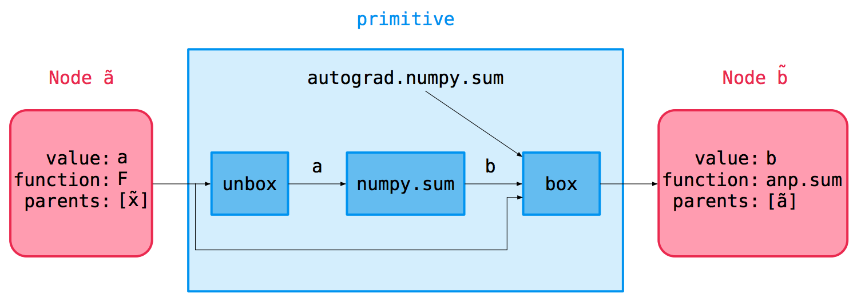

Therefore, it is worth being more careful about setting the function from which we are going to get the gradient:

- use special mathematical functions from the ``autograd`` library itself (``import autograd.numpy as anp``)
- when multiplying vectors/matrices, also use operations either pure ``python`` (``@``), or also from the library

In the example below, the first function written in pure ``numpy`` is not suitable for calculating the gradient (*grad()* method from the library) using this library for many reasons:
- basic - any special mat. function should be taken from ``autograd.numpy``;
- by itself, the use of ``.dot()`` from ``numpy`` is harmless (you can check by removing mean), because the result of the operation will be *numpy.array* from a single float. But it is worth bearing this in mind if this is not the last operation
- because when adding ``mean()``, an intermediate calculation of the sum is used before division (i.e. two operations are counted), which requires the ``autograd`` type *ArrayBox* for the argument (see the last function)

In [4]:
W = np.array([[1.5, 0],
              [0, 1.]
             ])
w = np.array([1.5, 0])

def logistic(x: np.ndarray):
    return 1./(1 + np.exp(-np.dot(x, W).mean()))

def logistic_1(x: np.ndarray):
    return 1./(1 + anp.exp(-np.dot(x, W).mean()))

def logistic2(x: np.ndarray):
    print(type(x@W))
    return 1./(1 + anp.exp(-anp.mean(x@W)))

grad_example = autograd.grad(logistic2)
print(grad_example(np.zeros(2)))

<class 'autograd.numpy.numpy_boxes.ArrayBox'>
[0.1875 0.125 ]


To understand how the derivatives themselves are calculated in libraries using the concept of ``autodiff``, it is important to realize that they:
- do not explicitly use difference schemes (since *forward pass* can be heavy)
- rely on the procedure for computrations of functions/their gradients, and **do not** differentiate symbolically

**Instead,** libraries use pre-calculated products of **vector-Jacobian** (let's discuss them again in pytorch) for mathematical functions:

For the vector-function $\mathbf{y}=f(\mathbf{x})$, where
$\mathbf{x}=\langle x_1,\dots,x_n\rangle$ and
$\mathbf{y}=\langle \mathbf{y}_1,\dots,\mathbf{y}_m\rangle$, the derivative
$\mathbf{y}$ on $\mathbf{x}$ sets with *Jacobi matrix*:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial \mathbf{y}_{1}}{\partial \mathbf{x}_{1}} & \cdots & \frac{\partial \mathbf{y}_{1}}{\partial \mathbf{x}_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial \mathbf{y}_{m}}{\partial \mathbf{x}_{1}} & \cdots & \frac{\partial \mathbf{y}_{m}}{\partial \mathbf{x}_{n}}
      \end{array}\right)\end{align}

Then the vector of the derivative string for a particular vector $\mathbf{\overline{x}}$ is obtained by multiplying $\mathbf{\overline{x}} = \mathbf{\overline{y}}^T\mathbf{J}$

But the Jacobi matrix is not calculated when forming the calculation graph. It is this product that is used. Let's demonstrate, for example, for the function $\mathbf{y} = g(\mathbf{x}) = \exp(\mathbf{x})$.

The gradient calculation function *takes* the gradient from the previous node $\mathbf{\overline{y}} = \mathbf{g}$, the output value $\mathbf{y}=\mathbf{ans}$ and the input arguments $\mathbf{x}$ and *outputs* the input gradient $\mathbf{\overline{x}}$.

Examples from the library:

```
defvjp(exp, lambda g, ans, x: ans * g)
defvjp(log, lambda g, ans, x: g / x)
defvjp(multiply, lambda g, ans, x, y: y * g,
                 lambda g, ans, x, y: x * g)
```

The above were used *lambda functions* - a term from the theory of algorithms and functional programming. In python, the FP paradigm is partially implemented due to these functions - they allow you to set unnamed functions (in the interpreter, you can call as an anonymous function) without internal variables (which allows less memory and stack usage, for example).

For more examples, see, for example, https://realpython.com/python-lambda/

In [5]:
def f1(x: np.ndarray):
    return x.T @ x

def f2(x: np.ndarray):
    return anp.sin(x[0]**2) * anp.exp(-x.T @ x/5)

def f3(x: np.ndarray):
    norm2 = x.T @ x
    if norm2 == 0.:
        return 0.
    else:
        return x[0] * x[1]**2/ (x[0]**2 + x[1]**4)

def f4(x: np.ndarray):
    return (x[0]**3 + x[1]**3)**(1/3)

C:\Users\Georgy\AppData\Local\Temp\ipykernel_19988\263624279.py:15: RuntimeWarning: invalid value encountered in scalar power
  return (x[0]**3 + x[1]**3)**(1/3)


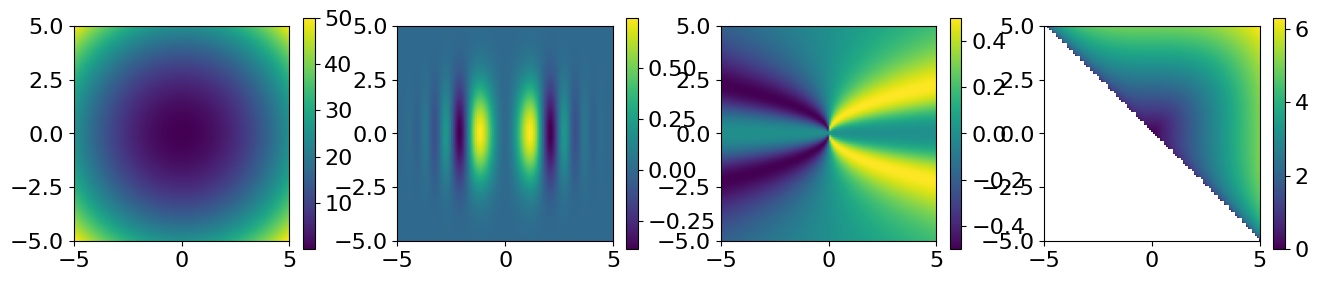

In [6]:
_x = np.linspace(-5, 5, 100)
_y = np.linspace(-5, 5, 100)
X_mesh, Y_mesh = np.meshgrid(_x, _y)
coordinates = np.stack([X_mesh, Y_mesh]).reshape((2, -1))
funcs = [f1, f2, f3, f4]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for i, f in enumerate(funcs):
    img = axes[i].imshow(np.apply_along_axis(f, 0, coordinates).reshape((100, 100)), 
                     extent=(-5, 5, -5, 5), origin='lower')
    fig.colorbar(img, ax=axes[i])

(Question) What do we expect from the 3 and 4 functions in the framework of gradient calculations derived in the direction?

### **(Task 1) Write the code for counting partial derivatives of the functions above**

Let's calculate the partial derivatives by the symmetric finite difference formula:
\begin{equation}
\frac{\partial f}{\partial x_i} \approx \frac{f(\dots, x_i + \varepsilon, \dots) - f(\dots, x_i - \varepsilon, \dots)}{2\varepsilon}
\end{equation}

In [7]:
def dfdx_i(f: callable, 
           x: np.ndarray,
           i=0,
           eps=1e-3
          ):
    step_x = np.zeros_like(x)
    step_x[i] = eps
    return (f(x + step_x) - f(x - step_x))/2/eps

**As a test of your implementation, calculate the gradients of the function $f_1$ in points (0, 0), (10, 0) and (5, 5).**

In [8]:
grad_f1_0 = [dfdx_i(f1, np.zeros(2), i) for i in range(2)] # your code here
grad_f1_10 = [dfdx_i(f1, np.array([10, 0.]), i) for i in range(2)] # your code here
grad_f1_5 = [dfdx_i(f1, np.array([5, 5.]), i) for i in range(2)] # your code here

***To test your solution, for example, we will use the autograd library.***

In [9]:
from autograd import grad 
assert np.allclose(grad_f1_0, grad(f1)(np.zeros(2)))
assert np.allclose(grad_f1_10, grad(f1)(np.array([10, 0.])))
assert np.allclose(grad_f1_5, grad(f1)(np.array([5, 5.])))

We warmed up... Now the task is more serious - let us have the exact gradient of the function $f_2$.

In [10]:
def true_grad_f2(x: np.ndarray):
    return np.array([np.exp(-x.T @ x/5) * (2*x[0]*np.cos(x[0]**2) - 0.4*np.sin(x[0]**2)*x[0]), 
                     -np.sin(x[0]**2) * np.exp(-x.T @ x/5) * 0.4 * x[1]
                    ])

**Calculate for different eps values the norm of the difference between the numerical gradient and the theoretical one at the point (5., 2.)**

In [11]:
grad_norms = []

_point = np.array([5, 2.]) 
eps_range =  np.logspace(-8, -1, 100000) ### your code here ###
for eps in tqdm(eps_range):
    grad_norms.append(
        np.linalg.norm(np.array([dfdx_i(f2, _point, i, eps=eps) for i in [0, 1]]) -
                       true_grad_f2(_point))
    )


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:08<00:00, 11316.10it/s]


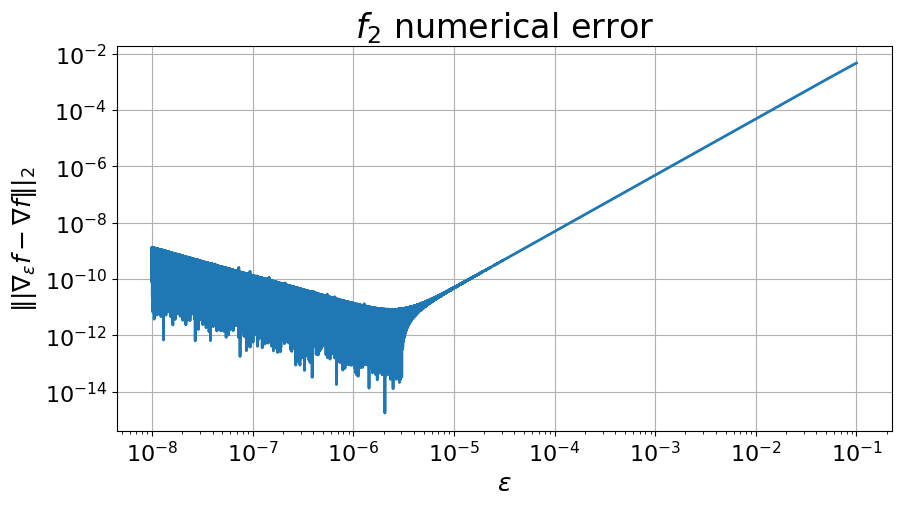

In [12]:
plt.loglog(eps_range, grad_norms)
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\|| \nabla_{\varepsilon}f - \nabla f \||_2$")
plt.title(r"$f_2$ numerical error")
plt.grid();

***Questions for reflection:***
- What is the reason for this behavior?
- Why is there such a growth at the left end? Isn't it more logical to take a step less and less?)
- Is it possible to reproduce this behaviour with the $f_1$ function?

#### QA)

For more detailed answers and 4-point schemes, see  https://www.uio.no/studier/emner/matnat/math/MAT-INF1100/h09/kompendiet/chap11.pdf

Firstly, let's answer on the third question - "is it possible to reproduce?"

It is possible, but in a rather impractical way - it seems illogical to take a very big step.

In [13]:
def true_grad_f1(x: np.ndarray):
    return 2*x

In [14]:
grad_norms = []

_point = np.array([10, 5.]) 
eps_range = np.logspace(-4, 4, 100000)
for eps in tqdm(eps_range):
    grad_norms.append(np.linalg.norm(np.array([dfdx_i(f1, _point, i, eps=eps) for i in [0, 1]]) - true_grad_f1(_point)))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 30240.95it/s]


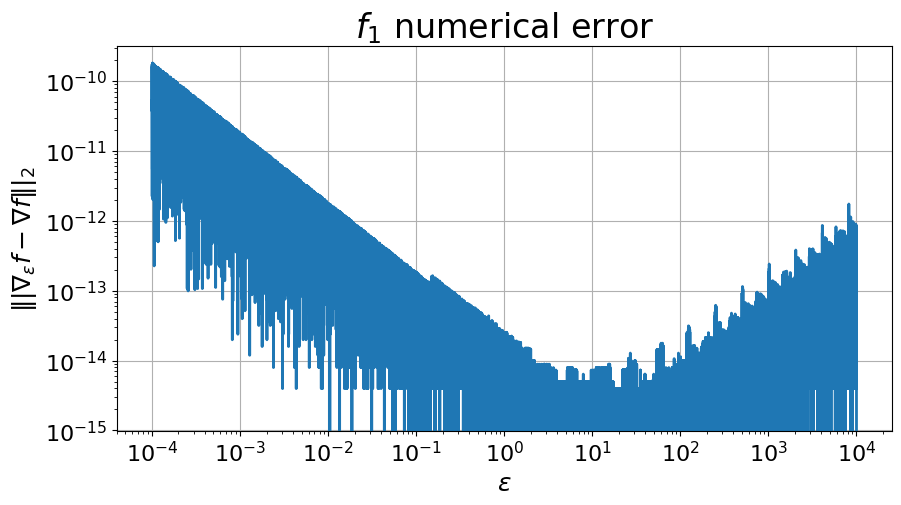

In [15]:
plt.loglog(eps_range, grad_norms)
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\|| \nabla_{\varepsilon}f - \nabla f \||_2$")
plt.title(r"$f_1$ numerical error")
plt.grid();

**And what is the root cause of this behavior?**

Consider the series of the function with differences:
\begin{gather}
f(\mathbf{x} + \varepsilon \mathbf{e}) = f(\mathbf{x}) + \langle \nabla f(\mathbf{x}), \varepsilon \mathbf{e}\rangle + O(\varepsilon^2) \\
\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} + O(\varepsilon)
\end{gather}

The last expression is a formula for calculating the derivative in the direction of $\mathbf{e}$.


Let's estimate which $\varepsilon$ to take for an accurate calculation?

**From the point of view of limits, it is more logical to take $\varepsilon$ as little as possible. BUT we are limited by machine accuracy - float will not pull too small a value (**

Let $fl(x)$ be a representation of a real number in float format, $\varepsilon_m$ be machine precision. Then it is true that
$$|fl(x) - x| \leq \varepsilon_m |x|$$
Let's estimate what minimum error is possible between the float representation of the gradient and its $\varepsilon$ calculation:
\begin{gather}
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right| = \left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle + \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right) + \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} - \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right| \leq \\
\leq \underbrace{\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right|}_{\text{doesn't depend on } \varepsilon} + \underbrace{\left|\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle - \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right|}_{\leq \frac{L_2}{2} \varepsilon} + \underbrace{\left|\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} - fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right|}_{\text{Division doesn't suppress the accuracy}} \leq \\
\leq const + \frac{L_2}{2} \varepsilon + \left|\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - fl\left(f(\mathbf{x} + \varepsilon \mathbf{e})\right) - (f(\mathbf{x}) - fl\left(f(\mathbf{x})\right))}{\varepsilon}\right| \leq \\
\leq const + \frac{L_2}{2} \varepsilon + \frac{L_0 \varepsilon_m + L_0 \varepsilon_m}{\varepsilon} = const + \frac{L_2}{2} \varepsilon + \frac{2 L_0 \varepsilon_m}{\varepsilon} \rightarrow \min_{\varepsilon}
\end{gather}

In these notations, $L_2$ is a restriction of the value of the second derivatives in the neighborhood for any direction $\mathbf{e}$ (the smoothness property of the function), $L_0$ is a similar restriction of the function.

From the minimization, we find the optimal $\varepsilon$ and the upper limit on the representation error:
\begin{gather}
\frac{L_2}{2} - \frac{1}{\varepsilon^2} 2 L_0 \varepsilon_m = 0 \Rightarrow \quad \varepsilon = 2\sqrt{\frac{L_0 \varepsilon_m}{L_2}} \approx \sqrt{\varepsilon_m} \\
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right| \leq \frac{L_2}{2} 2\sqrt{\frac{L_0 \varepsilon_m}{L_2}} + \frac{2 L_0 \varepsilon_m}{2\sqrt{\frac{L_0 \varepsilon_m}{L_2}}} = \sqrt{L_0 L_2 \varepsilon_m} + \sqrt{L_0 L_2 \varepsilon_m} = 2\sqrt{L_0 L_2 \varepsilon_m}
\end{gather}

(OPTIONAL)
We used a symmetric scheme, it has less mathematical approximation error. For it, the evaluation is as follows (the steps are the same, you can show the expansion to $O(\varepsilon^3)$):
\begin{gather}
\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon} + O(\varepsilon^2) \\
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon}\right)\right| \leq \frac{L_3}{6}\varepsilon^2 + \frac{L_0 \varepsilon_m + L_0 \varepsilon_m}{2\varepsilon} \rightarrow \min_{\varepsilon} \\
\varepsilon = \sqrt[3]{\frac{3L_0 \varepsilon_m}{L_3}} \Rightarrow \quad \left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon}\right)\right| \leq \sqrt[3]{L_3 L_0^2 \varepsilon_m^2}\left(\frac{\sqrt[3]{9}}{6} + \frac{\sqrt[3]{9}}{3}\right) = \frac{\sqrt[3]{9 L_3 L_0^2 \varepsilon_m^2}}{2}
\end{gather}

**Finally: The reason for the behaviour on the plot (and the differences in the behaviour of $f_1$ and $f_2$) in:**
- Dependence of the approximation error of derivatives on machine accuracy
- Limitation of the error by Lipschitz constants for the second/third derivatives and the values of the functions themselves

### **Task 2. Derivatives in the direction. Complex decomposition**

Generally speaking, we are able to do complex decompositions. Can they help us?

YES!

\begin{gather}
f(\mathbf{x} + i\varepsilon \mathbf{e}) = f(\mathbf{x}) + \langle \nabla f(\mathbf{x}), i\varepsilon \mathbf{e}\rangle - \frac{1}{2} \langle\mathbf{e}, \nabla^2 f(\mathbf{x}) \mathbf{e}\rangle\varepsilon^2 + iO(\varepsilon^3) \\
Im(f(\mathbf{x} + i\varepsilon \mathbf{e})) = \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle \varepsilon + O(\varepsilon^3) \Rightarrow \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{Im(f(\mathbf{x} + i\varepsilon \mathbf{e}))}{\varepsilon} + O(\varepsilon^2)
\end{gather}

This estimate does not contain difference schemes, which makes it possible to improve the estimate in the case of approximation of $\varepsilon$ to machine accuracy.
Let's illustrate this with the example of $f_2, f_3, f_4$.

**Using the gradient calculation code from the previous task, implement the gradient calculation in the direction.**

In [16]:
def df_direction(f: callable, 
                 x: np.ndarray,
                 e: np.ndarray,
                 eps=1e-3
                ):
    _nabla = np.array([dfdx_i(f, x, i, eps=eps) for i in [0, 1]])
    return np.dot(_nabla, e)

**Compare for different $\varepsilon$ the results of your implementation and the complex approximation (code below) on the unit direction with the theoretical gradient of the function $f_2$**

For reference: ``python`` implements a mechanism for working with complex numbers. The imaginary unit variable `1j` is reserved for this, and such numbers have the attributes `real`, `imag`.

The ``numpy`` library, in continuation, allows you to operate with complex vectors and calculate functions from them (there are also `np.real`, `np.imag`).

In [17]:
complex_num = 3j + 4
print(complex_num.real, complex_num.imag,
      abs(complex_num))

4.0 3.0 5.0


In [18]:
def df_dir_complex(f: callable, 
                   x: np.ndarray,
                   e: np.ndarray,
                   eps=1e-3
                  ):
    return np.imag(f(x + 1j*eps*e))/eps

In [19]:
directional_diffs = []
im_directional_diffs = []

_e = np.array([1, 1.]) 
_point = np.array([5, 2.]) 
eps_range = np.logspace(-12, -3, 100000) 
for eps in tqdm(eps_range):
    directional_diffs.append(abs(df_direction(f2, _point, _e, eps=eps) - true_grad_f2(_point).dot(_e)))
    im_directional_diffs.append(abs(df_dir_complex(f2, _point, _e, eps=eps) - true_grad_f2(_point).dot(_e)))

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:11<00:00, 8564.10it/s]


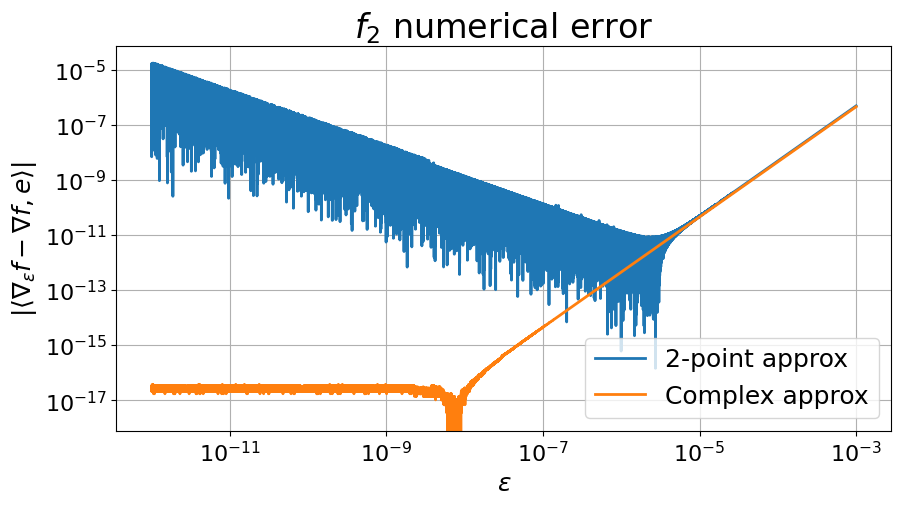

In [20]:
plt.loglog(eps_range, directional_diffs, label="2-point approx")
plt.loglog(eps_range, im_directional_diffs, label="Complex approx")
plt.legend()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$| \langle\nabla_{\varepsilon}f - \nabla f, e\rangle|$")
plt.title(r"$f_2$ numerical error")
plt.grid();

**Results:**

If it is possible to use the complex representation of the function, this type of approximation allows you to achieve machine accuracy.

For the application of the complex approximation in physics, see https://provost.utsa.edu/undergraduate-research/journal/files/vol2/UJRSW.Roussel.Millwater.pdf

**Last comment**

Let's look at two functions that have derivatives in directions, but they are not differentiable (because the derivatives are not continuous).

Let's try to calculate the gradients in the direction at point (0, 0) with the autograd library and hands using a complex representation.

In [21]:
autograd_f3 = grad(f3)
autograd_f4 = grad(f4)

In [22]:
_point = np.array([0, 0.]) 

Let's choose 8 directions and see what values the complex approximation takes:

In [23]:
directions = np.array([[-1, -1.],
                       [0, -1.],
                       [-1, 0],
                       [0, 1],
                       [1, 0],
                       [1, 1],
                       [-1, 1],
                       [1, -1]
                      ]) 
print("f3 directional derivatives")
for _e in directions:
    print(f"({_e[0]}, {_e[1]}): Complex={df_dir_complex(f3, _point, _e, eps=1e-10):.3f},\
    2-points={df_direction(f3, _point, _e, eps=1e-10):.3f},\
    autograd={autograd_f3(_point).dot(_e):.3f}")

f3 directional derivatives
(-1.0, -1.0): Complex=-1.000,    2-points=0.000,    autograd=0.000
(0.0, -1.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(-1.0, 0.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(0.0, 1.0): Complex=0.000,    2-points=0.000,    autograd=0.000
(1.0, 0.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(1.0, 1.0): Complex=1.000,    2-points=0.000,    autograd=0.000
(-1.0, 1.0): Complex=-1.000,    2-points=0.000,    autograd=0.000
(1.0, -1.0): Complex=1.000,    2-points=0.000,    autograd=0.000


C:\Users\Georgy\AppData\Local\Programs\Python\Python311\Lib\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [24]:
print("f4 directional derivatives")
for _e in directions:
    print(f"({_e[0]}, {_e[1]}): Complex={df_dir_complex(f4, _point, _e, eps=1e-10):.3f},\
    2-points={df_direction(f4, _point, _e, eps=1e-10):.3f},\
    autograd={autograd_f4(_point).dot(_e):.3f}")

f4 directional derivatives
(-1.0, -1.0): Complex=0.630,    2-points=nan,    autograd=nan
(0.0, -1.0): Complex=0.500,    2-points=nan,    autograd=nan
(-1.0, 0.0): Complex=0.500,    2-points=nan,    autograd=nan
(0.0, 1.0): Complex=-0.500,    2-points=nan,    autograd=nan
(1.0, 0.0): Complex=-0.500,    2-points=nan,    autograd=nan
(1.0, 1.0): Complex=-0.630,    2-points=nan,    autograd=nan
(-1.0, 1.0): Complex=0.000,    2-points=nan,    autograd=nan
(1.0, -1.0): Complex=0.000,    2-points=nan,    autograd=nan


C:\Users\Georgy\AppData\Local\Temp\ipykernel_19988\263624279.py:15: RuntimeWarning: invalid value encountered in scalar power
  return (x[0]**3 + x[1]**3)**(1/3)
C:\Users\Georgy\AppData\Local\Programs\Python\Python311\Lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: divide by zero encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
C:\Users\Georgy\AppData\Local\Programs\Python\Python311\Lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in scalar multiply
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


**Question:**

~~What's going on?~~
- Why does the complex approximation give such values in the first case?
- Who is right in the second case?

Answers:

- In the first case (as everywhere when using the complex approximation), we want the function to be differentiable. But this is not the case - at point 0, this function is not differentiable. The explanation is more detailed than words - [stackexchange](https://math.stackexchange.com/questions/367774/show-that-a-function-has-directional-derivatives-at-a-point-but-is-not-different) , [mathinsight](https://mathinsight.org/nondifferentiable_discontinuous_partial_derivatives )

- In the second case, everything is more interesting. Generally speaking, no one is right) In theory, partial derivatives of this function exist at zero, they are equal to 1 (see [stackexchange](https://math.stackexchange.com/questions/673975/function-has-partial-derivatives-but-is-not-differentiable)). The complex approximation tries to cope with their existence, but the trouble comes from the other side - the function is not differentiable at zero. ~~This is a defeat, no one can cope with this loss~~

## Computational Graph in the Pytorch library

From the first part of the seminar, it can be noted that we often want to calculate the gradient from the vector function $f:\mathbb{R}^m\rightarrow \mathbb{R}^n,$ and not ordinary functions. Yes, with the help of *autograd* or *jax* we can already calculate this, and even with matrices we can do something.

Let's see how the *pytorch* library allows you to calculate these values!

The material is based on the structure of the MSU seminar on [DL course](https://github.com/nadiinchi/dl_labs/blob/master/lab_pytorch.ipynb ). In the same place, the possibilities for writing code for training neural networks are analyzed in more detail. We will consider only the possibilities necessary for solving optimization problems.


### Pytorch basics

Let's go through the basics - in fact, *pytorch* is very similar to *numpy*, but operates with *tensors* as an elementary unit of operations:

In [25]:
x = np.arange(16).reshape(4, 4)
print('Type x:', type(x))
x_torch = torch.arange(0, 16).view(4, 4).float()
print('Type x_torch:', type(x_torch))


print("x:\n" +f"{x}")
print("x + 42:\n" +f"{x+42}")

print("x_torch:\n" +f"{x_torch}")
print("x_torch + 42:\n" +f"{x_torch+42}")

Type x: <class 'numpy.ndarray'>
Type x_torch: <class 'torch.Tensor'>
x:
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
x + 42:
[[42 43 44 45]
 [46 47 48 49]
 [50 51 52 53]
 [54 55 56 57]]
x_torch:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
x_torch + 42:
tensor([[42., 43., 44., 45.],
        [46., 47., 48., 49.],
        [50., 51., 52., 53.],
        [54., 55., 56., 57.]])


Differences in operations are minimal and are easily found in [documentation](https://pytorch.org/docs/stable/index.html ) and google (Stackoverflow/tutorials):

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.LongTensor)
```
You can convert one to the other

```
torch.from_numpy(npx) -- returns Tensor
tt.numpy() -- returns Numpy Array
```

In [26]:
print("x*x^T:\n" +f"{np.dot(x, x.T)}")
print("x_torch*x_torch^T:\n" + f"{torch.matmul(x_torch, x_torch.transpose(1, 0))}")
print()
print("Mean over columns:\n" + f"{x.mean(axis=-1)}")
print("Mean over columns tensor:\n" + f"{torch.mean(x_torch, dim=-1)}")
print()
print("Columns cumulative sum:\n" + f"{np.cumsum(x, axis=0)}")
print("Columns cumulative sum tensor:\n" + f"{torch.cumsum(x_torch, dim=0)}")

x*x^T:
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
x_torch*x_torch^T:
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])

Mean over columns:
[ 1.5  5.5  9.5 13.5]
Mean over columns tensor:
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])

Columns cumulative sum:
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]
Columns cumulative sum tensor:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Also, the *pytorch* interface allows you to create a tensor from a *numpy* array and convert types:

In [27]:
y = torch.from_numpy(x)
print('Type of y:', type(y))
y = torch.from_numpy(x).type(torch.FloatTensor)
print('Type of y', type(y))

Type of y: <class 'torch.Tensor'>
Type of y <class 'torch.Tensor'>


#### In-place operations

Now we are working with tensors, and ~~most often~~ sometimes they can be huge.
Therefore, the possibility of *in-place* operations is provided, which allows you not to create a new object in memory, but to modify an existing one.
```
x.exp()   # not-in-place operation
x.exp_()  # in-place operation
```

In [28]:
x = torch.arange(4).float()
print('Not-in-place:')
print('\tx.exp():\t\t', x.exp().numpy())
print('\tx:\t\t\t', x.numpy())
print('In-place:')
print('\tx.exp_():\t\t', x.exp_().numpy())
print('\tx after x.exp_():\t', x.numpy())

Not-in-place:
	x.exp():		 [ 1.         2.7182817  7.389056  20.085537 ]
	x:			 [0. 1. 2. 3.]
In-place:
	x.exp_():		 [ 1.         2.7182817  7.389056  20.085537 ]
	x after x.exp_():	 [ 1.         2.7182817  7.389056  20.085537 ]


*In-place* operations allow you to reduce the number of intermediate tensors allocated during the calculation process:

In [29]:
x = torch.arange(0, 4).view(2, 2)
y = torch.arange(4, 8).view(2, 2)
z = torch.arange(8, 12).view(2, 2)

# Not-in-place:
u = x + 2 * y - z    # 3 array allocations?
print(u.numpy())

# In-place
u = y.clone()        # 1 array allocation
u.mul_(2)
u.add_(x)
u.sub_(z)
print(u.numpy())

[[0 2]
 [4 6]]
[[0 2]
 [4 6]]


#### Broadcasting in pytorch

Just like in *numpy*, a mechanism is provided for expanding the shape of arrays to combine and perform operations on initially different (by dimensions) arrays. More in *pytorch* this mechanism is described in http://pytorch.org/docs/master/notes/broadcasting.html

In [30]:
a = torch.Tensor([1, 1, 1, 2]).view(4, 1)
b = torch.Tensor([1, 0, 1, 0]).view(1, 4)
c = torch.randn(16).view(4, 4)
print('a:', a)
print('b:', b)
print('a + b:', a + b)
print('c:', c)
print('b + c:', b + c)

a: tensor([[1.],
        [1.],
        [1.],
        [2.]])
b: tensor([[1., 0., 1., 0.]])
a + b: tensor([[2., 1., 2., 1.],
        [2., 1., 2., 1.],
        [2., 1., 2., 1.],
        [3., 2., 3., 2.]])
c: tensor([[-0.4606, -1.3959,  0.7830,  0.8617],
        [-1.2831,  1.2198, -2.0681, -1.5607],
        [ 1.5428,  0.6744, -0.6582,  0.7190],
        [ 0.0441, -0.0097, -0.2793, -0.4130]])
b + c: tensor([[ 0.5394, -1.3959,  1.7830,  0.8617],
        [-0.2831,  1.2198, -1.0681, -1.5607],
        [ 2.5428,  0.6744,  0.3418,  0.7190],
        [ 1.0441, -0.0097,  0.7207, -0.4130]])


### Computational graph

And now let's talk about what we are here for)

Conceptually, autograd stores a record of data (tensors) and all operations performed (together with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function_ objects.
In this DAG, *leaves* are input tensors, *roots* are output tensors. Due to the complete path from the leaves to the roots, the required gradients can be calculated using the chain-rule.

With a **forward** pass, autograd does two things at the same time:

- performs the requested operation to calculate the result into a tensor
- supports operation gradient function in DAG.

**Backward** the pass begins when the function *.backward()* is called at the root of the DAG. then autograd:

- calculates gradients from each .grad_fn,
- accumulates them in an attribute .grad of the corresponding tensor
- using chain rule, extends up to finite tensors.

Let's build this computational graph :

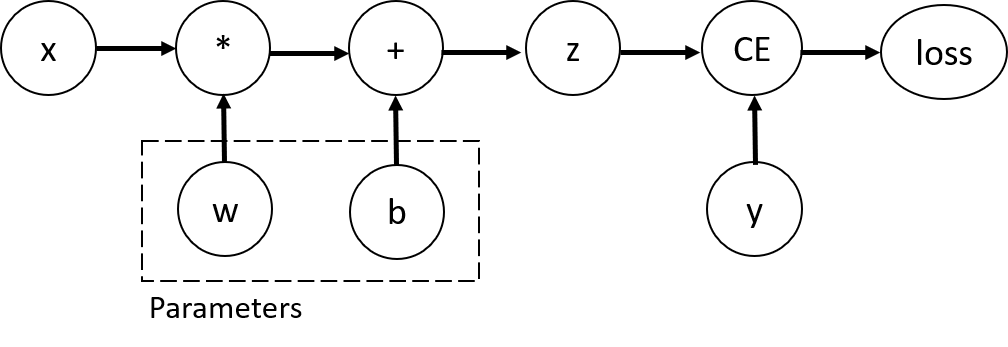

To start forming the calculation graph, you must specify the input variables with the flag ``require_grad``:

In [31]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # ouptput values vector
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

As mentioned earlier, grad_fn is also stored for each Function object at *backpropagation*.

For more complex chain-rule examples on the calculation graph, you can see [CSC321](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec06.pdf)

In [32]:
print(f"Grad function for z = {z.grad_fn}")
print(f"Grad function for loss = {loss.grad_fn}")

Grad function for z = <AddBackward0 object at 0x00000149613B4BE0>
Grad function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x00000149613B69E0>


**In order to calculate gradients is called .backward() passage from the root with scalar output**

In [33]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1279, 0.0934, 0.1297],
        [0.1279, 0.0934, 0.1297],
        [0.1279, 0.0934, 0.1297],
        [0.1279, 0.0934, 0.1297],
        [0.1279, 0.0934, 0.1297]])
tensor([0.1279, 0.0934, 0.1297])


By default, all variables with ``require_grad=True`` are tracked to calculate the gradient later. To stop tracking the operations performed with them, you can use the ``.no_grad()`` mode

In [34]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


You can also apply the ``detach()`` method to the tensor

In [35]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


This may be required when:
- Training neural networks to freeze some parameters.
- Optimization of the calculation speed. Since only *forward will be performed for these variables*

Also **it is important to remember** that the graph accumulates gradients when calling *backward()*. Therefore, it is important not to forget about this when optimizing.

### Examples of functions and vector functions

In the case of vector functions, pytorch uses **Jacobian product** rather than calculating the gradient.

For a vector function $\vec{y}=f(\vec{x})$, where
$\vec{x}=\langle x_1,\dots,x_n\rangle$ and
$\vec{y}=\langle y_1,\dots,y_m\rangle$, derivative
$\vec{y}$ on $\vec{x}$ sets with Jacobi matrix:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

Instead of calculating the Jacobi matrix, pytorch calculates **Jacobian Product** $v^T\cdot J$ for a given input vector $v=(v_1\dots v_m)$. To do this, we submit an argument to the `backward`. The size of the argument must be equal to the size of the tensor by which we take the derivative

In [36]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call \n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call \n{inp.grad}")

inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing grads\n{inp.grad}")

First call 
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call 
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing grads
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


In addition, for frantic variables, the library also allows you to save gradients using ``retain_grad()``

In [37]:
x = torch.randn(4, requires_grad=True)   # leaf vars
z = torch.randn(4, requires_grad=True)   # leaf vars
w = z * 2      # not leaf vars
y = x * w + 1  # forward pass before retain_grad can be done easily
p = y.sum()

w.retain_grad()

p.backward()
print('dp / dx:', x.grad)
print('dp / dz:', z.grad)
print('dp / dw:', w.grad)

dp / dx: tensor([ 3.0863, -0.8427, -2.2330,  0.4285])
dp / dz: tensor([-1.0144,  0.2106,  1.5544, -1.0461])
dp / dw: tensor([-0.5072,  0.1053,  0.7772, -0.5230])


### Let's optimize something

You are given some ~~strange~~ loss function that causes a linear transformation to map points of 10-dimensional space into a 2-dimensional circle with radius 1. You should use gradient descent on the transformation parameters.

The linear transformation of a 10-dimensional point $x$ to a 2-dimensional point $y$ has weights $W$ and $b$ and looks like this:
$$y = Wx + b$$

The norm of two-dimensional Euclidean space:
$$||y||_2 = \sqrt{y_1^2 +y_2^2}$$

The loss function $f_0$ penalizes the point $y$ for moving away from the circle of radius 1:
$$f_0(x,W,b) = 0.5 \cdot \big| ||y||_2 - 1 \big| + \big( ||y||_2 - 1 \big)^2$$

Unfortunately, optimization by $f_0$ by $W$ and $b$ can be carried out analytically and outputs $W = 0$, $b = (1, 0)$.
To avoid such a solution, we also penalize the proximity of $y$ to $b$. This penalty turns into $0$ if the distance from $y$ to $b$ is greater than $1$:
$$f_1(x,W,b)= \max\big(0, \frac{1}{||y - b||_2} - 1\big)$$

The final loss function looks like this:
$$f(x, W, b) = f_0(x, W, b) + f_1(x, W, b)$$

You need to solve the following optimization problem:
$$\frac{1}{N}\sum\limits_{i= 1}^N f(x_i,W,b) \to\min\limits_{W,b}$$

In [38]:
X = torch.randn(50, 10)
b = torch.randn(2)
W = torch.randn(10, 2)

In [39]:
def f(X, W, b):
    biased_y_norm = torch.norm(X.mm(W).add(b), dim=-1)
    return (
        0.5 * torch.abs(biased_y_norm - 1) 
        + (biased_y_norm - 1)**2 
        + torch.maximum(torch.zeros(X.size(0)), 1/torch.norm(X.mm(W), dim=-1) - 1) 
    ).mean()
    

In [40]:
print(f(X, W, b))

tensor(24.1307)


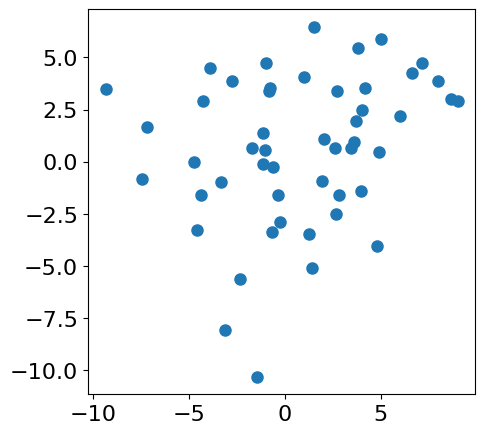

In [41]:
plt.figure(figsize=(5, 5))
Y = X.mm(W).add(b)
plt.scatter(Y[:, 0], Y[:, 1]);

In [42]:
# This implementation is not so perfect for pytorch, but good)
gamma = 2e-1
max_iter = 15

b = torch.randn(2, requires_grad=True)
W = torch.randn(10, 2, requires_grad=True)

for i in range(max_iter):
    loss = f(X, W, b)
    loss.backward()
    
    W.data -= gamma * W.grad.data
    b.data -= gamma * b.grad.data
    
    W.grad.data.zero_()
    b.grad.data.zero_()
    gamma /= 1.01
    print(loss.item())

13.744955062866211
4.1729021072387695
1.8756611347198486
1.1366665363311768
0.8316598534584045
0.6755825877189636
0.5852100849151611
0.5362376570701599
0.50852370262146
0.4902171790599823
0.4751928448677063
0.4587990641593933
0.44251906871795654
0.4295278787612915
0.4202377200126648


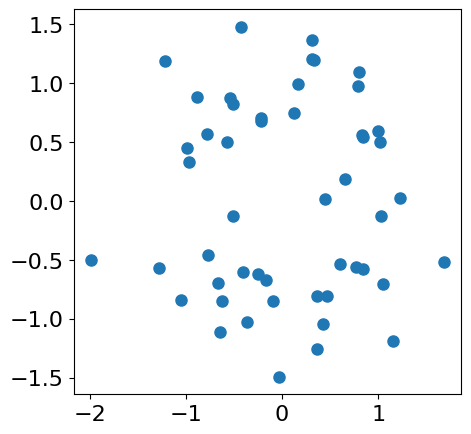

In [47]:
plt.figure(figsize=(5, 5))
Y = X.mm(W.detach()).add(b.detach())
plt.scatter(Y[:, 0], Y[:, 1]);

#### Block of tasks for interest

1. (Task of interest) Implement (find a simple implementation) of a fully connected neural network. Play around with optimisers Is it possible to make a circle perfect?

2. Solve the puzzle using pytorch. ((Found [здесь](https://machinelearningmastery.com/using-autograd-in-pytorch-to-solve-a-regression-problem/))
```
[ A ]  +  [ B ]  =  9
  +         -
[ C ]  -  [ D ]  =  1
  =         =
  8         2
```

### Finally. How to get Hesse and Jacobi matrices?

Pytorch, in addition to calculating the Jacobian product, allows you to directly get the Jacobi and Hesse matrix.

Let's look at a simple function, how to do this:

In [44]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.5857]), tensor([0.5887]))


(tensor([[3.5925]]), tensor([[3.]]))

The first output should be equal to $2e^x$, and the second should be 3.

**Naturally, this can be done with tensors of a larger order**

In [45]:
inputs = (torch.rand(3), torch.rand(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.5096, 0.2687, 0.3558]), tensor([0.7356, 0.2801, 0.6383]))


(tensor([[3.3292, 0.0000, 0.0000],
         [0.0000, 2.6165, 0.0000],
         [0.0000, 0.0000, 2.8546]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

The method `torch.autograd.functional.hessian()` for a doubly differentiable function works similarly (computing the Hessian matrix). Only the function should return a single number...

In [46]:
def pow_adder_reducer(x, y):
    return (2 * x.pow(2) + 3 * y.pow(2)).sum()

inputs = (torch.rand(2), torch.rand(2))
torch.autograd.functional.hessian(pow_adder_reducer, inputs)

((tensor([[4., 0.],
          [0., 4.]]),
  tensor([[0., 0.],
          [0., 0.]])),
 (tensor([[0., 0.],
          [0., 0.]]),
  tensor([[6., 0.],
          [0., 6.]])))

You can also directly calculate the Jacobi product ($j$) on the vector ($v$) - vjp\jvp

In [76]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([1158.5569, -354.3551, -534.6226]),
 tensor([5.1200e+01, 5.1200e+02, 5.1200e-02]))

The methods `vhp()` and `hvp()" count products already with the Hesse matrix.

For more information, you can see [documentation](https://pytorch.org/docs/stable/autograd.html#functional-higher-level-api )_

## Automatic differentiation in the Jax library

### What is JAX?

'Google JAX` is another `python` framework for machine learning and optimization, allowing you to write highly efficient code using `GPU/TPU` using [`XLA`] (https://www.tensorflow.org/xla ) (Accelerated Linear Algebra is a domain-oriented linear algebra compiler). The framework implements its own `autodiff`, as well as useful features of `compilation` and `parallelization`, which we will talk about a little later.

In many cases, the `API` of the `JAX` framework coincides with the `API` of the `numpy` framework, so most often `JAX` is imported into the code via `import jax.numpy as np` (that is, with the same nickname as `numpy`).

### TL;DR

Example of finding gradients, Jacobians and hessians:

1. Import `jax.numpy` to write functions in a language understandable to `jax` language

In [27]:
import jax
import jax.numpy as jnp


def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)


def f_vec(x: np.ndarray):
    """
    R^n -> R^n
    """
    return jnp.sin(x)

2. To get the gradient of the function, you need to use `jax.grad()`

In [28]:
grad_f2 = jax.grad(f2_float)
print(f"grad at x = 0, y = 0: {grad_f2(np.array([0., 0.]))}")

grad at x = 0, y = 0: [0. 0.]


3. To get the Jacobian you need to use either `jax.jacfwd`, or `jax.jacrev` (on functions of the form R^n -> R coincides with the gradient).

In [29]:
jacf_f2 = jax.jacfwd(f2_float)
jacb_f2 = jax.jacrev(f2_float)
print(f"Jacobian forward pass at x = 0, y = 0: {jacf_f2(np.array([0., 0.]))}")
print(f"Jacobian backward pass at x = 0, y = 0: {jacb_f2(np.array([0., 0.]))}")

Jacobian forward pass at x = 0, y = 0: [0. 0.]
Jacobian backward pass at x = 0, y = 0: [0. 0.]


In [30]:
jac_f_vec = jax.jacfwd(f_vec)
print(f"Jacobian forward pass at x = 0, y = 0:\n{jac_f_vec(np.array([0., 0.]))}")

Jacobian forward pass at x = 0, y = 0:
[[1. 0.]
 [0. 1.]]


4. To get the Hessian, it is enough to consistently apply the calculation of the Jacobian.

In [31]:
hesse_f_f2 = jax.jacfwd(jax.jacfwd(f2_float))
print(f"Hesse at x = 0, y = 0:\n{hesse_f_f2(np.array([0., 0.]))}")

Hesse at x = 0, y = 0:
[[2. 0.]
 [0. 0.]]


### Why 'JAX`?

1. Speed:


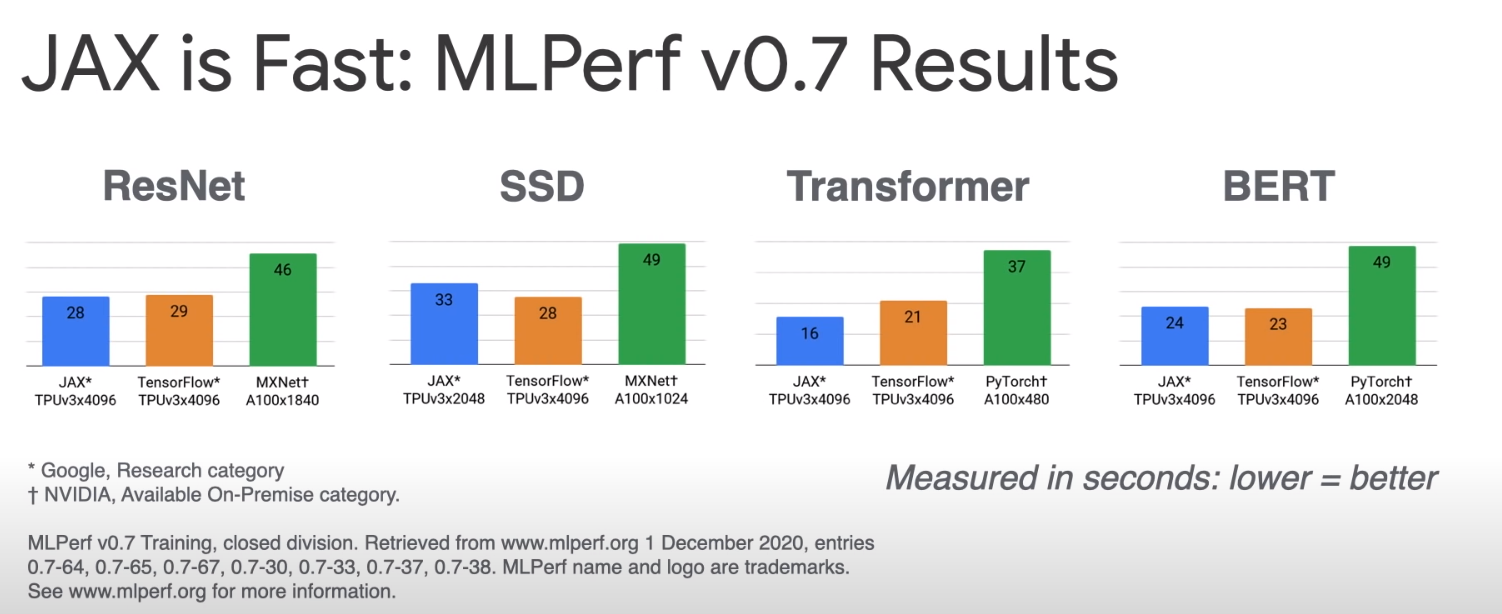

The picture is taken from [video](https://www.youtube.com/watch?v=WdTeDXsOSj4&t=1s )

2. Similarity of `API` with `Numpy` and `Scipy'.

3. The ability to use `autodiff` using the 'grad` function.

4. The ability to vectorize the code using the `vmap` function (to work without loops).

5. The ability to compile part of the code using the `jit` (just-in-time compilation) function, which greatly speeds up their work.

6. The possibility of code parallelization using the `pmap' function, which allows you to use several cores of the computing system.

7. 'JAX` includes
- High-level libraries for deep learning: `Flax, Haiku, Trax`
- libraries for optimization: `JAXOpt, Optax`
- - libraries for [probabilistic programming](https://habr.com/en/articles/244625 /): `Oryx, TFP-jax, NumPyro`
- libraries for working with [graph neural networks] (https://habr.com/en/companies/vk/articles/557280 /): `Jraph`
- And much more...

### How does `JAX` do this?

Without going into details, we can say that `JAX` tracks every function that the developer has written, rewrites it into its own convenient form, which can be immediately used by `autodiff, vmap, pmap, jit`.

### Код

In [33]:
# Check the platform for evaluations
from jax.lib import xla_bridge

print(f"Current computation platform is {xla_bridge.get_backend().platform}")
# JAX will preallocate 75% of the total GPU memory when the first JAX operation is run.

Current computation platform is cpu


In [34]:
# By default it is in float32
# But we can change it

jax.config.update("jax_enable_x64", True)

#### `Just-In-Time`

A few words about `jit`: `jit` tracks what happens in each function, recompiles them and caches their use. If we call a `jit` function, and the next time we call it again with *similar* input data, then the already cached function will be called. "*similar*" means, for example, those input data that have the same dimensions (in the sense of linear algebra). You can read more about it here: [jax.jit](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html )

#### Example

In [35]:
def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)

In [36]:
f2_float_jitted = jax.jit(f2_float)
print(f"jitted at x = 0, y = 0: {f2_float_jitted(np.array([0., 0.]))}")

jitted at x = 0, y = 0: 0.0


You can also use **decorators**:

In [37]:
@jax.jit
def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)


print(f"jitted at x = 0, y = 0: {f2_float(np.array([0., 0.]))}")

jitted at x = 0, y = 0: 0.0


#### What functions can be handled by 'jit'?

It is important to understand that not all functions can be processed by `jit`, so, for example, the following code will cause an error:

In [38]:
@jax.jit
def non_jitable(x):
    return x[x > 0]


try:
    non_jitable(np.array([-1, 2, -3]))
except Exception as e:
    print(e)

Array boolean indices must be concrete; got ShapedArray(bool[3])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError


Moreover, `jit` will not track *side-effects* in functions, such as the functions `print('hi')` and `global_list.append('hi')` will be ignored during compilation, so there will be no effect when running with `jit`:

In [39]:
global_list = []


def impure_func(x):
    print("hi")
    ln_x = jnp.log(x)
    global_list.append("hi")
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2


x = np.array([1, 2, 3])

print("==No jit==")
impure_func(x)
print(global_list)

print("==jit first run==")
# Non cached run
# On this step jit traces the function
impure_func_jited = jax.jit(impure_func)
impure_func_jited(x)
print(global_list)

print("==jit second run==")
# Cached run
impure_func_jited(x)
print(global_list)

print("==jit third run==")
# Getting traced again (x is of len 4)
x = np.array([1, 2, 3, 4])
impure_func_jited(x)
print(global_list)

==No jit==
hi
['hi']
==jit first run==
hi
['hi', 'hi']
==jit second run==
['hi', 'hi']
==jit third run==
hi
['hi', 'hi', 'hi']


**And what functions are possible?**

You can [clean](https://en.wikipedia.org/wiki/Pure_function#:~:text=In%20computer%20programming%2C%20a%20pure,arguments%20or%20input%20streams%2C%20and):

Informal definition:
1. All input data is passed through function parameters, all results are output through function results.
2. A pure function will always return the same result if it is called with the same input data.

It is important that all variables are sent immediately to an available accelerated device (No need to write `.to(device)` as in `torch`), and arrays in `jax` are immutable!


#### Random numbers in `JAX`

Getting random variables in `jax` is different from getting them in `numpy`. There are a number of reasons for this, for example, the random number generator in `numpy` has a global state `state`, which is updated every time the function returns a random number. Now imagine that we are paralleling the process of executing the function: now the result may depend on the order in which the kernels "grab" the random number generators, that lego violates the second point in the definition of a pure function.

Getting random numbers in `jax` has important properties:

1. reproducible

2. parallelizable

3. vectorisable

In [40]:
key = jax.random.PRNGKey(42)
subkeys = jax.random.split(key, 3)

print()
print(f"state = {key}: {jax.random.normal(key, (1,))}")
# State will not update on second call
print("second call:", jax.random.normal(key, (1,)))

# New states
for subkey in subkeys:
    print(f"state = {subkey}: {jax.random.normal(subkey, (1,))}")


state = [ 0 42]: [-2.16982456]
second call: [-2.16982456]
state = [3134548294 3733159049]: [-1.16959583]
state = [3746501087  894150801]: [-0.21746704]
state = [ 801545058 2363201431]: [0.17814184]


#### Example

Consider the functional:
$$
f(x) = \|Ax - b\|^2_2;\\x, b\in\mathbb{R^n}, A\in\mathbb{R}^{n\times n}
$$

As we already know, the gradient of this functional is:
$$
\nabla f(x)= 2 \cdot A^\top (Ax - b)
$$

And Hessian:
$$
\nabla^2 f(x) = 2 A^\top A
$$

In [41]:
@jax.jit
def f(x, A, b):
    res = A @ x - b
    return res @ res


def f_np(x, A, b):
    res = A @ x - b
    return res @ res


def gradf_np(x, A, b):
    return 2 * A.T @ (A @ x - b)


gradf = jax.grad(f, argnums=0, has_aux=False)

# argnums = 0 by default, by a number or a sequence of numbers
# you can set variables by which the partial derivative will be calculated

# has_aux = False by default, if True, it is assumed that
# # f returns a number as the first argument (which counts as a gradient),
# And the second additional information

In [42]:
n = 5000
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (n,))
A = jax.random.normal(key, (n, n))
b = jax.random.normal(subkeys[0], (n,))

x_np = np.random.normal(size=(n,)).astype("float64")
A_np = np.random.normal(size=(n, n)).astype("float64")
b_np = np.random.normal(size=(n,)).astype("float64")

In [43]:
# Compute gradient

print("Check correctness", jnp.linalg.norm(gradf(x, A, b) - 2 * A.T @ (A @ x - b)))
print("Compare speed")
print("=========================")
print("Analytical gradient")
res = %timeit -o -q 2 * A.T @ (A @ x - b)
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Analytical gradient numpy")
res = %timeit -o -q gradf_np(x_np, A_np, b_np)
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Grad function")
res = %timeit -o -q gradf(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
jit_gradf = jax.jit(gradf)
print("Jitted grad function")
res = %timeit -o -q jit_gradf(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")

Check correctness 2.46956917123497e-09
Compare speed
Analytical gradient
36.81  ms
Analytical gradient numpy
30.938  ms
Grad function
11.698  ms
Jitted grad function
11.057  ms


Note that the `.block_until_ready` method is used so that `python` waits for the result from the executable code, and does not continue calculations with other code. The need to use this arises because the calculations are performed by `XLA`, not `python`, so an asynchronous process occurs (see `Asynchronous dispatch').

#### Jacobi matrix computation

Let's slightly change our functionality to demonstrate different ways of calculating the Jacobi matrix:
$$
f(x) = Ax - b;\\x\in\mathbb{R^n} , b\in\mathbb{R^m}, A\in\mathbb{R}^{m\times n}
$$

Now $f: \mathbb{R}^n\to\mathbb{R}^m$

The Jacobian of this mapping is very simple:
$$
J = A
$$

In [44]:
@jax.jit
def f_vec(x, A, b):
    res = A @ x - b
    return res

`jacfwd' counts the Jacobian using forward-mode automatic differentiation (more efficient for "standing" matrices). `jacrev` counts the Jacobian using reverse-mode (more efficient for "wide" matrices).

In [45]:
# jacfwd vs jacrev
n = 10
mul = 200 
# f : R^(3n) -> R^n
x_wide = jax.random.normal(key, (mul * n,))
A_wide = jax.random.normal(key, (n, mul * n))
b_wide = jax.random.normal(subkeys[0], (n,))

# f : R^n -> R^(3n)
x_tall = jax.random.normal(key, (n,))
A_tall = jax.random.normal(key, (mul * n, n))
b_tall = jax.random.normal(subkeys[0], (mul * n,))

jit_jac_fwd = jax.jit(jax.jacfwd(f_vec))
jit_jac_rev = jax.jit(jax.jacrev(f_vec))

params = [(x_tall, A_tall, b_tall), (x_wide, A_wide, b_wide)]
params_names = ['tall', 'wide']

methods = [jit_jac_fwd, jit_jac_rev, jit_gradf]
methods_names = ['jit_jac_fwd', 'jit_jac_rev', 'jit_gradf']

for params, params_name in zip(params, params_names):
    print(f'=========={params_name}==========')
    x, A, b = params
    print(f'matrix A shape = {A.shape}')
    print()

    for method, method_name in zip(methods, methods_names):
        print(f'==={method_name}===')
        a = %timeit -n 1000 -r 7 -o -q method(x, A, b).block_until_ready()
        print(f'{round(a.average * 1e3, 3)} ms')

==========tall==========
matrix A shape = (2000, 10)

===jit_jac_fwd===
0.016 ms
===jit_jac_rev===
1.432 ms
===jit_gradf===
0.01 ms
==========wide==========
matrix A shape = (10, 2000)

===jit_jac_fwd===
1.591 ms
===jit_jac_rev===
0.021 ms
===jit_gradf===
0.01 ms


Counting the Hessian product on a vector:

In [46]:
def hvp(f, x, z, *args):
    """
    computes hesse_f(x) * z
    """

    def g(x):
        return f(x, *args)

    return jax.jvp(jax.grad(g), (x,), (z,))[1]

In [47]:
n = 1000
x = jax.random.normal(key, (n,))
A = jax.random.normal(key, (n, n))
b = jax.random.normal(subkeys[0], (n,))
z = jax.random.normal(subkeys[1], (n,))

P.S. `static_argnum: int | Sequence[int]` is an argument for the `max.jit` function, which allows you to fix the function argument with the number `static_argnums` at compile time

In [48]:
# Hessian vector product 

print("Check correctness", jnp.linalg.norm(2 * A.T @ (A @ z) - hvp(f, x, z, A, b)))

print("Time for hvp by hands")
res = %timeit -o -q (2 * A.T @ (A @ z)).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

print("Time for hvp via jvp, NO jit")
res = %timeit -o -q hvp(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

print("Time for hvp via jvp, WITH jit")
res = %timeit -o -q jax.jit(hvp, static_argnums=0)(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

Check correctness 9.543199294979256e-11
Time for hvp by hands
1.122  ms
Time for hvp via jvp, NO jit
1.011  ms
Time for hvp via jvp, WITH jit
0.295  ms


In [49]:
# hvp vs hessian * vector

jax_hvp_times = []
my_hvp_times = []
ns = [10, 100, 500, 1000, 2500]

jit_hvp = jax.jit(hvp, static_argnums=0)
for curr_n in ns:
    print(f'curr n is {curr_n}')
    n = curr_n
    x = jax.random.normal(key, (n,))
    A = jax.random.normal(key, (n, n))
    b = jax.random.normal(key, (n,))
    z = jax.random.normal(key, (n,))

    res = %timeit -o -q jit_hvp(f, x, z, A, b).block_until_ready()
    jax_hvp_times.append(round(res.average * 1e3, 3))

    res = %timeit -o -q (2 * A.T @ (A @ z)).block_until_ready()
    my_hvp_times.append(round(res.average * 1e3, 3))

curr n is 10
curr n is 100
curr n is 500
curr n is 1000
curr n is 2500


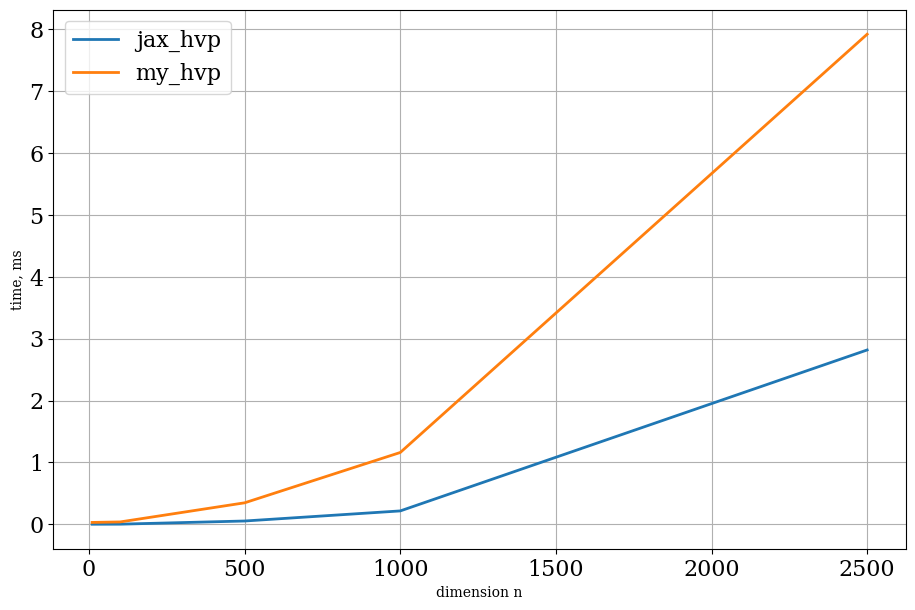

In [50]:
plt.plot(ns, jax_hvp_times, label="jax_hvp")
plt.plot(ns, my_hvp_times, label="my_hvp")
plt.xlabel("dimension n")
plt.ylabel("time, ms")
plt.grid()
plt.legend()
plt.show()